# 2D LEGI analysis with NNE and ISD communication models

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.draw import sheet_view
import os
import pingouin as pg
import pickle
from sklearn.cluster import KMeans
import matplotlib.colors as mcl
import matplotlib
import math
from matplotlib.collections import PatchCollection

/Users/jonathan/Desktop/MUNCHEN/Project_AVE_migration/AVE_model/LIS_DIFFUSION/SIMULATION_EPITHELIUM/epi-venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
conf_folder='./CONF/'
ISD_folder='./ISD/'

figures_folder='./2DLEGI_FIGURES/'

if os.path.isdir(figures_folder)==False:
    os.mkdir(figures_folder)

# Figure 2

Plot the configurations belonging to set1 (set of 30 random configurations with different number of cells and mean polygon number)

In [4]:
fig2_folder=figures_folder+'FIG2/'

if os.path.isdir(fig2_folder)==False:
    os.mkdir(fig2_folder)

In [5]:
# Choose the set to plot
set_str='set1'

stages=['hexa1_','hexa2_','hexa3_','hexa4_','hexa5_','hexa6_']
sheets=[]
k=0
for i in stages:
    for j in range(5):
        dsets = hdf5.load_datasets(conf_folder+set_str+'_sheet_'+i+str(j)+'.hf5',
                                   data_names=['vert', 'edge', 'face'])
        sheet = Sheet(i+str(j), dsets)
        sheets.append(sheet)
        k+=1

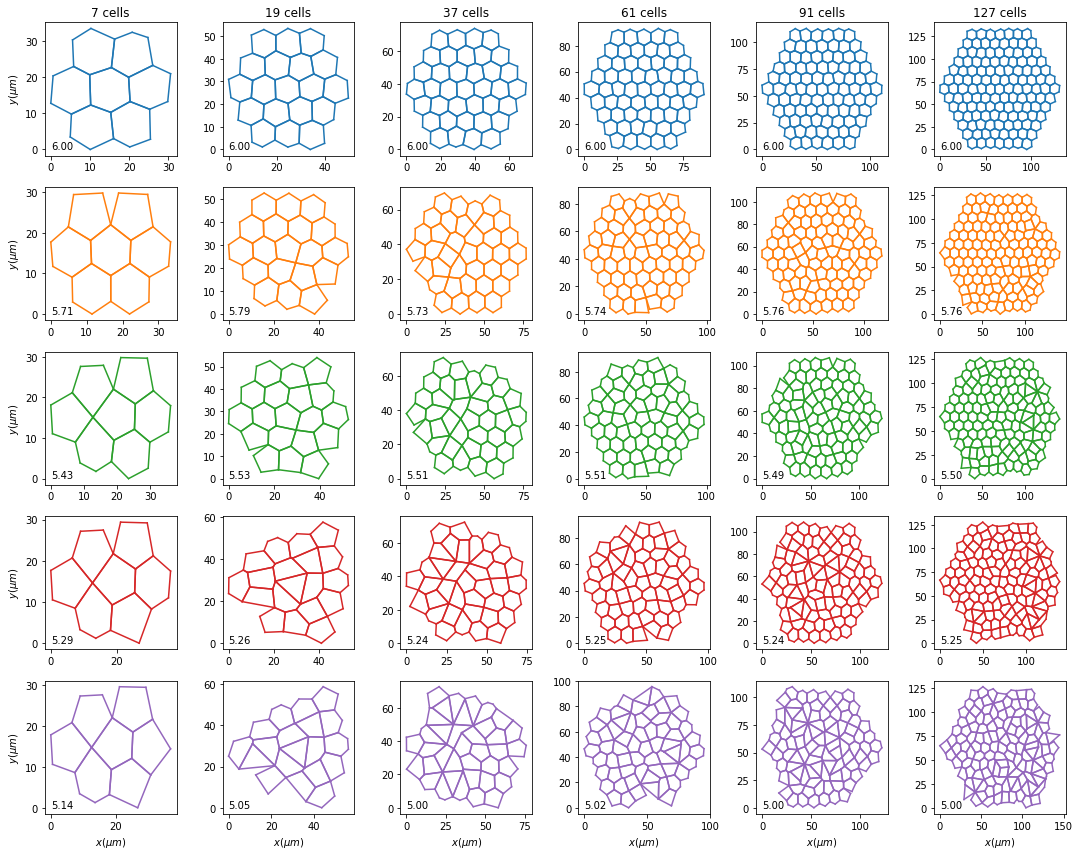

(None, None)

In [6]:
fig,ax=plt.subplots(5,6,figsize=(15,12))
colors=['C0','C1','C2','C3','C4']
k=0
for i in range(len(stages)):
    for j in range(5):
        for e in sheets[k].edge_df.index:
            if i==0:
                ax[j,i].set_ylabel(r'$y (\mu m)$')
            if j==0:
                ax[j,i].set_title('%d cells' % (sheets[k].Nf))
            if j==4:
                ax[j,i].set_xlabel(r'$x (\mu m)$')
            ax[j,i].plot([sheets[k].edge_df.loc[e]['sx'],sheets[k].edge_df.loc[e]['tx']],
                        [sheets[k].edge_df.loc[e]['sy'],sheets[k].edge_df.loc[e]['ty']],color=colors[j])
        ax[j,i].text(x=0,y=0,s='%.2f' % (sheets[k].face_df['num_sides'].mean()))
        k+=1

fig.tight_layout()
# plt.savefig(fig2_folder+'FIG_2A'+date+'.pdf',bbox_inches='tight'),plt.close()
plt.show(),plt.close()

# Figure 3

We plot the exchange rate matrices for an example configuration in the two communication models, the nearest neighbour exchange (NNE) and intercellular space diffusion (ISD) modes. We represent the configuration as a weighted graph, with the weights given by the exchange rates.

In [7]:
fig3_folder=figures_folder+'FIG3/'

if os.path.isdir(fig3_folder)==False:
    os.mkdir(fig3_folder)

## Plots

In [8]:
# Load a configuration
dsets = hdf5.load_datasets(conf_folder+'set1_sheet_hexa1_4.hf5',data_names=['vert', 'edge', 'face'])
sheet = Sheet('hexa1', dsets)

In [9]:
import networkx as nx
 
def plot_weighted_graph(s,gamma_mat,model,nn):
    
    plt.figure(figsize=(6,5))

    if model=='ISD':
        model_color='C0'
        title_str='ISD communication'
        plot_str='FIG3C'
    elif model=='NNE':
        model_color='C1'
        title_str='NNE communication'
        plot_str='FIG3B'
 
    G = nx.Graph() 
    node_list = [str(ident) for ident in s.face_df.index]
    for node in node_list:
        G.add_node(node)
 
    pos=dict(zip(node_list, np.array(s.face_df[['x','y']])))
    
    nx.draw_networkx_nodes(G,pos,node_color=model_color,node_size=600)
 
    labels = {}
    for node_name in node_list:
        labels[str(node_name)] =str(node_name)
    nx.draw_networkx_labels(G,pos,labels,font_size=16)
 
    for i in range(s.Nf):
        for j in range(i):
            if j!=i and gamma_mat[i,j]>0.:
                if j in nn[i]:
                    G.add_edge(node_list[i],node_list[j],weight=gamma_mat[i,j],style='solid'
                               ,connectionstyle='arc3, rad = 0.0')
                else:
                    G.add_edge(node_list[i],node_list[j],weight=gamma_mat[i,j],style='dashed'
                               ,connectionstyle='arc3, rad = -0.6')
                
    styles = nx.get_edge_attributes(G,'style').values()
    conn = nx.get_edge_attributes(G,'connectionstyle').values()
    weights = nx.get_edge_attributes(G,'weight').values()
    
    j=0
    for e in G.edges():
        if np.abs(int(e[0])-int(e[1]))==1:
            nx.draw_networkx_edges(G,pos,edgelist=[e],width=50*list(weights)[j],
                              style=list(styles)[j],connectionstyle=list(conn)[j])
        else:
            nx.draw_networkx_edges(G,pos,edgelist=[e],width=50*list(weights)[j],
                              style=list(styles)[j],connectionstyle=list(conn)[j])
        j+=1
 
    #Plot the graph
    plt.axis('off')
    plt.title(title_str,size=16)
    plt.show(),plt.close()

#     plt.savefig(fig2_folder+plot_str+'.pdf',bbox_inches='tight'),plt.close() 

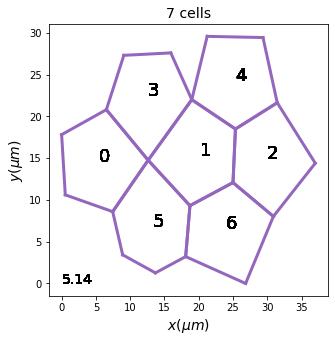

In [10]:
fig,ax=plt.subplots(figsize=(5,5))
for e in sheet.edge_df.index:
    ax.set_ylabel(r'$y (\mu m)$',fontsize=14)
    ax.set_title('%d cells' % (sheet.Nf),fontsize=14)
    ax.set_xlabel(r'$x (\mu m)$',fontsize=14)
    ax.plot([sheet.edge_df.loc[e]['sx'],sheet.edge_df.loc[e]['tx']],
                [sheet.edge_df.loc[e]['sy'],sheet.edge_df.loc[e]['ty']],color='C4',lw=3)
    ax.text(x=0,y=0,s='%.2f' % (sheet.face_df['num_sides'].mean()),fontsize=14)
    for i, txt in enumerate(sheet.face_df.index):
        ax.annotate(txt, (sheet.face_df['x'].loc[i], sheet.face_df['y'].loc[i]),fontsize=18)  
# plt.savefig(fig3_folder+'FIG3A.pdf',bbox_inches='tight'),plt.close()


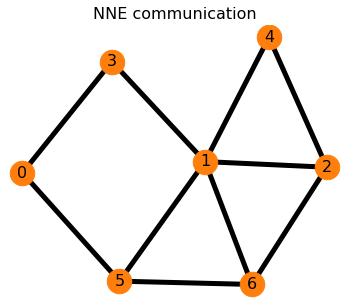

In [11]:
# Compute the exchange rate matrix for the NNE model
gamma=0.1

nn_list=[list(sheet.get_neighbors(j)) for j in range(sheet.Nf)]
ex_rate_mat_NN=np.zeros((sheet.Nf,sheet.Nf))
for k in range(ex_rate_mat_NN.shape[0]):
    ex_rate_mat_NN[k,nn_list[k]]=gamma

plot_weighted_graph(sheet,ex_rate_mat_NN,'NNE',nn_list)

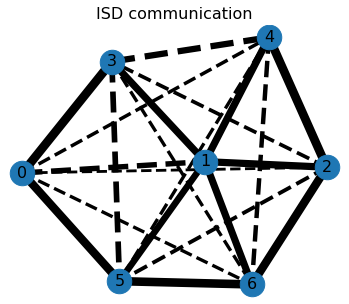

In [12]:
subfolder='set1_Results_D1000.0_l1.0/'
res_folder=ISD_folder+subfolder
filehandler = open(res_folder+"Matrices_simulation_hexa1_4.ISD", 'rb')
res_matrices = pickle.load(filehandler)
ex_rate_mat_ISD=1.0*res_matrices[1]
np.fill_diagonal(ex_rate_mat_ISD,0)

plot_weighted_graph(sheet,ex_rate_mat_ISD,'ISD',nn_list)

# Figure 4

Different communication regimes in the ISD communication model. 

In [13]:
fig4_folder=figures_folder+'FIG4/'

if os.path.isdir(fig4_folder)==False:
    os.mkdir(fig4_folder)

## Functions

In [14]:
def PlotGammaDist(s,gammat,output_folder,panel_label,save=True):
    
    x_coords=np.array(s.face_df['x'])
    y_coords=np.array(s.face_df['y'])
        
    xy_coords=np.column_stack((x_coords,y_coords))
        
    kmeans_s = KMeans(n_clusters=1, random_state=0).fit(xy_coords)
    centre_s = kmeans_s.cluster_centers_[0]
        
    dist_centroid=np.sqrt( (x_coords - centre_s[0])**2 + (y_coords - centre_s[1])**2 )
        
    idx_min=np.argmin(dist_centroid)
        
    dist_min=np.sqrt( (x_coords - x_coords[idx_min])**2 + (y_coords - y_coords[idx_min])**2 )
    arr1=gammat[idx_min,:].copy()
    fig,ax=plt.subplots()
    PlotSNR2(s,s.identifier,arr1,idx_min,'C3',r'$\gamma/\gamma_{max}$',fig,ax)
    if save==False:
        plt.show(),plt.close()
    else:
        plt.savefig(output_folder+panel_label+'.pdf',bbox_inches='tight'),plt.close()

# Find the indices of the neighbours of the central cell up to order 4
def idx_neighbours(s):
    # Find index of central cell
    x_coords=np.array(s.face_df['x'])
    y_coords=np.array(s.face_df['y'])
        
    xy_coords=np.column_stack((x_coords,y_coords))
        
    kmeans_s = KMeans(n_clusters=1, random_state=0).fit(xy_coords)
    centre_s = kmeans_s.cluster_centers_[0]
        
    dist_centroid=np.sqrt( (x_coords - centre_s[0])**2 + (y_coords - centre_s[1])**2 )
        
    idx_min=np.argmin(dist_centroid)
    
    first_neighbours_indices=list(s.get_neighbors(idx_min))
    second_neighbours_indices=[]
    for i in first_neighbours_indices:
        tmp_lst=list(s.get_neighbors(i))
        tmp_lst=[item for item in tmp_lst if item not in first_neighbours_indices and item!=idx_min]
        second_neighbours_indices+=tmp_lst
    third_neighbours_indices=[]
    for i in second_neighbours_indices:
        tmp_lst=list(s.get_neighbors(i))
        tmp_lst=[item for item in tmp_lst if item not in first_neighbours_indices and item not in second_neighbours_indices]
        third_neighbours_indices+=tmp_lst
    fourth_neighbours_indices=[]
    for i in third_neighbours_indices:
        tmp_lst=list(s.get_neighbors(i))
        tmp_lst=[item for item in tmp_lst if item not in third_neighbours_indices and item not in second_neighbours_indices]
        fourth_neighbours_indices+=tmp_lst
    
    return idx_min,[sorted(list(set(first_neighbours_indices))),sorted(list(set(second_neighbours_indices)))
            ,sorted(list(set(third_neighbours_indices))),sorted(list(set(fourth_neighbours_indices)))];
        
def PlotSNR2(s,stage,SNR,idx,color,cbar_label,fig,ax):
#     ax.set_title(stage)
    colors=SNR
    colors=np.delete(colors,idx)
    colors/=np.amax(colors)
    patches=[]
    for i in range(len(s.face_df)):
        centre=s.face_df[['x','y']].iloc[i]
        verts1=list(s.edge_df[s.edge_df['face']==s.face_df.index[i]]['trgt'])
        verts2=list(s.edge_df[s.edge_df['face']==s.face_df.index[i]]['srce'])
        verts=list(set(verts1+verts2))
        coord=np.array(s.vert_df[['x','y']].loc[verts])
        coord=[tuple(coord[j,:]) for j in range(len(coord))]
        coord.sort(key=lambda p: math.atan2(p[1]-centre[1],p[0]-centre[0]))
        if i!=idx:
            poly=matplotlib.patches.Polygon(coord,closed=True)
            patches.append(poly)
        else:
            polyX=matplotlib.patches.Polygon(coord,closed=True,color=color)
    p = PatchCollection(patches, edgecolor='black',linewidths=0.5,alpha=1.0)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    ax.axis('off')
    ax.autoscale_view()
    cbar=fig.colorbar(p, ax=ax)
    cbar.set_label(cbar_label)
    ax.add_patch(polyX)

## Plots

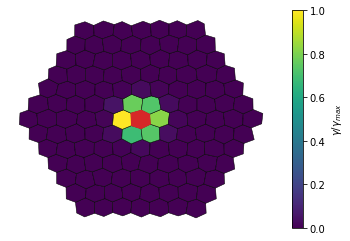

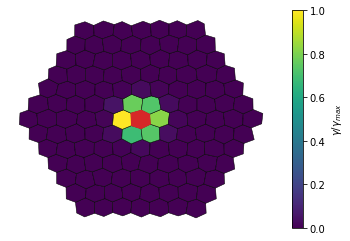

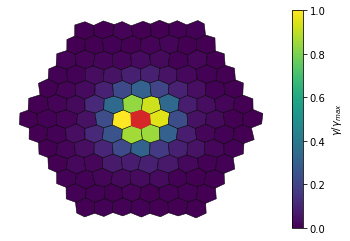

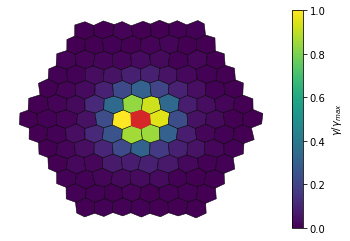

In [15]:
# Load a configuration
dsets = hdf5.load_datasets(conf_folder+'set1_sheet_hexa6_0.hf5',data_names=['vert', 'edge', 'face'])
sheet = Sheet('hexa6', dsets)

# Load the matrices for the different communication regimes
subfolders=['set1_Results_D10.0_l1.0/','set1_Results_D10.0_l1.0/',
            'set1_Results_D1000.0_l1.0/','set1_Results_D1000.0_l1.0/']
emrate_arr=[1.,100.0,1.,100.0]
panel_labels=['FIG4A','FIG4B','FIG4C','FIG4D']
comm_regimes=['Weak-local','Strong-local','Weak-global','Strong-global']
table_text=[[[r'$10.0\;\mu m^2/s$'],[r'$1.0\;s^{-1}$']],
           [[r'$10.0\;\mu m^2/s$'],[r'$100.0\;s^{-1}$']],
           [[r'$1000.0\;\mu m^2/s$'],[r'$1.0\;s^{-1}$']],
           [[r'$1000.0\;\mu m^2/s$'],[r'$100.0\;s^{-1}$']]]
lengths=[]
gammas=[]

cmapISD = matplotlib.cm.get_cmap('Blues')

ISD_colors = [cmapISD(0.2),cmapISD(0.4),cmapISD(0.6),cmapISD(0.8)]

for sub,pan,com,txt,emrate in zip(subfolders,panel_labels,comm_regimes,table_text,emrate_arr):
    filehandler = open(ISD_folder+sub+"Matrices_simulation_hexa6_0.ISD", 'rb')
    res_matrices = pickle.load(filehandler)
    ex_rate_mat_ISD=emrate*res_matrices[1]
    PlotGammaDist(sheet,ex_rate_mat_ISD,fig4_folder,pan,save=False)

In [16]:
# We compute the mean and standard deviation of the exchange rates with the central cell 
# for the first, second and third neighbours from the simulations, in the 4 communication
# regimes of the ISD model. We also show the prediction from the analytical calculation
lamb=1.0
NE_lst=[2,4,6]
D_lst=[10.,10.,1000.,1000.]
lE=sheet.edge_df['length'].mean()

idx_central,neighbours_list=idx_neighbours(sheet)
neighbours_labels=['First','Second','Third']
neighbours_order=[1,2,3]

gammas_lst=[]
order_lst=[]
regime_lst=[]
an_lst=[]
ord_lst=[]
reg_lst=[]

def P(lamb,l,N,D):
    return 1.-np.exp(-np.sqrt((lamb*N*N*l*l)/D))

# For each parameter regime and each order of neighbours, collect the values of the exchange rates
for sub,pan,com,emrate,D in zip(subfolders,panel_labels,comm_regimes,emrate_arr,D_lst):
    filehandler = open(ISD_folder+sub+"Matrices_simulation_hexa6_0.ISD", 'rb')
    res_matrices = pickle.load(filehandler)
    ex_rate_mat_ISD=emrate*res_matrices[1]
    for j,NE in zip(range(len(neighbours_list)),NE_lst):
        gammas=ex_rate_mat_ISD[idx_central,neighbours_list[j]]
        gammas_lst.append(list(gammas))
        order_lst.append([neighbours_labels[j]]*len(gammas))
        regime_lst.append([com]*len(gammas))
        if neighbours_labels[j]=='First':
            analytical=emrate*(P(lamb,lE,2,D)/6.)
        else:
            analytical=emrate*((P(lamb,lE,2,D)/(6*neighbours_order[j]))*(1.-P(lamb,lE,2*(neighbours_order[j]-1),D)))

        an_lst.append(analytical)
        ord_lst.append(neighbours_labels[j])
        reg_lst.append(com)

In [17]:
gamma_neighbours_df=pd.DataFrame(data={'gamma': [item for sublist in gammas_lst for item in sublist],
                                      'regime': [item for sublist in regime_lst for item in sublist],
                                      'order': [item for sublist in order_lst for item in sublist]})

analytical_df=pd.DataFrame(data={'gamma': an_lst,
                                      'regime':reg_lst,
                                      'order': ord_lst})

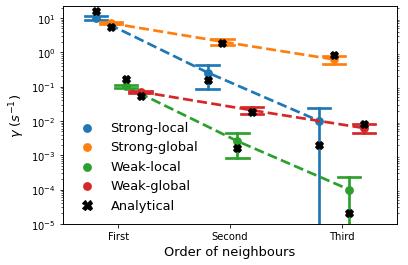

(None, None)

In [18]:
import matplotlib.lines as mlines

fig,ax=plt.subplots()
sns.pointplot(x="order", y="gamma", hue='regime',data=gamma_neighbours_df,
                   estimator=np.mean,ci='sd',dodge=.4,capsize=.2,
                  linestyles=["--", "--", "--", "--"],
                  hue_order=['Strong-local','Strong-global',
                             'Weak-local','Weak-global'],ax=ax)


ax2 = ax.twinx()
sns.pointplot(x="order", y="gamma", hue='regime',data=analytical_df, 
                    palette=['black','black','black','black'],
              markers=['X','X','X','X'],dodge=.4,capsize=.2,
             linestyles=["", "", "", ""],
                   hue_order=['Strong-local','Strong-global',
                             'Weak-local','Weak-global'],ax=ax2)
ax2.legend([],[], frameon=False)
ax.set_xlabel('Order of neighbours',fontsize=13)
ax.set_ylabel(r'$\gamma$ $(s^{-1})$',fontsize=13)
ax.set_ylim(0.00001,22)
ax2.set_ylim(0.00001,22)
ax2.set_ylabel('')
ax.set_yscale('log')
ax2.set_yscale('log')
ax2.set_yticks([])

handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
black_X = mlines.Line2D([], [], color='black', marker='X', linestyle='None',
                          markersize=10, label='Analytical')

# handles is a list, so append manual patch
handles.append(black_X) 

# plot the legend
ax.legend(handles=handles, loc=0, frameon=False,fontsize=13)
# fig.legend(frameon=False)
# plt.savefig(fig4_folder+'regimes.pdf',bbox_inches='tight'),plt.close()
plt.show(),plt.close()

# Results for the LEGI model

We compute the SNR defined in the LEGI model for all the configurations and the parameter settings in the ISD and NNE communication models.

We store the results in a single dataframe that we will subset depending on the figure.

In [19]:
import SNRfunctions as snr

## Functions

In [20]:
def SingleConfSNR(config,ex_rate_mat,set_label,name,MPN,model,LEGI_par_dict,param_label,num_theta=500):
    
    edgeSNR,mean,fluc=snr.LEGISNR(ex_rate_mat,config,beta=LEGI_par_dict['beta'],mu=LEGI_par_dict['mu'],
                                g=LEGI_par_dict['g'],a=LEGI_par_dict['a'],
                                cbar=LEGI_par_dict['cbar'],mode='mean_edge',num=num_theta)
    L=len(edgeSNR)
    SNR_df=pd.DataFrame(data={'set': [set_label]*L,
                             'name': [name]*L,
                             'nr_cells':[config.Nf]*L,
                             'MPN_lab': [MPN]*L,
                              'MPN': [config.face_df['num_sides'].mean()]*L,
                             'model': [model]*L,
                             'params': [param_label]*L,
                             'SNR': edgeSNR,
                             'mean': mean,
                             'fluc': fluc})
    return SNR_df;

def NNMatGen(config, ex_rate):
    nn_list=[list(config.get_neighbors(j)) for j in range(config.Nf)]
    ex_rate_mat=np.zeros((config.Nf,config.Nf))
    for k in range(ex_rate_mat.shape[0]):
        ex_rate_mat[k,nn_list[k]]=ex_rate
        
    return ex_rate_mat;

In [21]:
# Number of sets of random configurations
nr_sets=10

# Names of the configurations
config_names=['hexa1_','hexa2_','hexa3_','hexa4_','hexa5_','hexa6_']

# List with mean polygon number identifiers
MPN_list=['0','1','2','3','4']

subfolders_ISD=['Results_D10.0_l1.0/','Results_D10.0_l1.0/','Results_D1000.0_l1.0/','Results_D1000.0_l1.0/']
emrate_arr=[1.,100.0,1.,100.0]
regime_arr=['Weak-local','Strong-local','Weak-global','Strong-global']
# Values used for the exchange rate in the NNE model
ex_rate_list_NN=[0.1,10.0]

# Parameters of the LEGI model
LEGI_par_dict={'beta': 1.0,'mu':0.1,'g':0.04,'a':10,'cbar':10}

# Define an empty dataframe that will contain the values of the LEGI SNR for the configurations from all
# the sets, for all the parameter settings in the ISD and NNE communication models
Total_SNR_df=pd.DataFrame(columns=['set','name','nr_cells','MPN_lab','MPN','model','params','SNR','mean','fluc'])

# Labels for the different values of the mean polygon number (MPN)
for i in range(nr_sets):
    for j in config_names:
        for k in MPN_list:
            # Identifier for the configuration: set + name + MPN
            identifier='set'+str(i+1)+'_'+j+k
            # Load the configuration
            dsets = hdf5.load_datasets(conf_folder+'set'+str(i+1)+'_sheet_'+str(j)+str(k)+'.hf5',data_names=['vert', 'edge', 'face'])
            sheet = Sheet(identifier, dsets)
            
            # Loop over the parameter settings in the ISD model
            for (sub,emrate,reg) in zip(subfolders_ISD,emrate_arr,regime_arr):
                # Load the matrix of the exchange rates in the ISD model
                filehandler = open(ISD_folder+'set'+str(i+1)+'_'+sub+"Matrices_simulation_"+str(j)+str(k)+'.ISD', 'rb') 
                res_matrices = pickle.load(filehandler)
                ex_rate_mat_ISD=emrate*res_matrices[1]

                # Compute the SNR
                LEGI_ISD_df=SingleConfSNR(sheet,ex_rate_mat_ISD,'set'+str(i+1),j,k,'ISD',
                                          LEGI_par_dict,reg)
                
                # Add the results to the dataframe
                Total_SNR_df=Total_SNR_df.append(LEGI_ISD_df, ignore_index=True)
                
            # Loop over the parameter settings in the NNE model
            for ex_rate in ex_rate_list_NN:
                # Compute the matrix of the exchange rates in the NNE model
                ex_rate_mat_NN=NNMatGen(sheet, ex_rate)
                
                # Compute the SNR
                LEGI_NN_df=SingleConfSNR(sheet,ex_rate_mat_NN,'set'+str(i+1),j,k,'NNE',
                                          LEGI_par_dict,str(ex_rate))
                
                # Add the results to the dataframe
                Total_SNR_df=Total_SNR_df.append(LEGI_NN_df, ignore_index=True)

In [22]:
Total_SNR_df['MPN_lab']=Total_SNR_df['MPN_lab'].astype('category')

In [23]:
Total_SNR_df['MPN_lab'].cat.categories=['4','3','2','1','0']

# Figure 5

For each communication model and each parameter setting, we produce a boxplot for the SNR as a function of the number of cells (here we choose the configurations with larger mean polygon number), for 10 sets of configurations

We mark the p-values from the Wilcoxon rank-sum test as significant if they are smaller than 0.05 and if the common language effect size (CLES) is smaller than 0.4 or larger than 0.6.

In [24]:
fig5_folder=figures_folder+'FIG5/'

if os.path.isdir(fig5_folder)==False:
    os.mkdir(fig5_folder)

## Functions

In [25]:
sns.set(font_scale=2.0) 
sns.set(style='white')

def get_coordinates_of_seaborn_boxplot(ax):
    data_coordinates = []
    inv = ax.transData.inverted()    
    for c in ax.get_children():
        if type(c) == matplotlib.patches.PathPatch:
            x_coord=(c.get_extents().xmin+c.get_extents().xmax)/2
            y_coord=(c.get_extents().ymin+c.get_extents().ymax)/2
            data_coordinates.append(inv.transform(tuple([x_coord,y_coord])) )
    return data_coordinates

# Wilcoxon Rank sum between between all pairs of categories in the dataframe
def wilcoxon(df,cat_name,quant):
    
    # Get the number of categories in the given column
    lgth=len(df[cat_name].cat.categories)
    tmat=np.zeros((lgth,lgth))
    pmat=np.zeros((lgth,lgth))
    eff=np.zeros((lgth,lgth))
    
    i=0
    for l in df[cat_name].cat.categories:
        j=0
        sub_df1 = df[df[cat_name] == l]
        g1 = sub_df1[quant].values
        for l2 in df[cat_name].cat.categories:
            if l!=l2:
                sub_df2 = df[df[cat_name] == l2]
                g2 = sub_df2[quant].values
                w_res = pg.mwu(g1,g2,tail='two-sided')

                tmat[i,j]=w_res['U-val']
                pmat[i,j]=w_res['p-val']
                eff[i,j]=w_res['CLES']
            j+=1
        i+=1
    return tmat,pmat,eff;

def MyBoxPlot(df,x_axis_var,quant,set_label,color,output_folder,param_label,save=True):
    fig,ax=plt.subplots()
    
    g = sns.boxplot(x=x_axis_var, y=quant, data=df,ax=ax,color=color)
    df[x_axis_var]=df[x_axis_var].astype('category')
    coords = get_coordinates_of_seaborn_boxplot(g)
    g.set_xlabel('')
    if x_axis_var=='name':
        x_axis_cat=sorted(list(set(list(df['nr_cells']))))
        g.set_xticklabels([str(cat) for cat in x_axis_cat])
        g.set_xlabel('Number of cells')
    else:
        x_axis_cat=list(set(list(df['MPN_lab'])))
        g.set_xticklabels([5.0,5.25,5.5,5.75,6.0])
        g.set_xlabel('Mean polygon number')

    if quant=='SNR':
        g.set_ylabel(r'$ \sqrt{SNR}$')
    elif quant=='mean':
        g.set_ylabel(r'$ \Delta_N$')
    elif quant=='fluc':
        g.set_ylabel(r'$ \delta(\Delta_N)^2 $')
    else:
        print('The quantity that you want to plot does not exist in the dataframe')
    
    # Perform Wilcoxon Rank Sum test between all pairs 
    tmat,pmat,effmat=wilcoxon(df,x_axis_var,quant)
    
    lgth=len(df[x_axis_var].cat.categories)

    counter=0
    for j in range(lgth):
        for k in np.arange(j,lgth,1):
            if pmat[j,k]<0.05 and j!=k and np.abs(j-k)==1 and (effmat[j,k]<0.4 or effmat[j,k]>0.6):
                print('%.2f' % (effmat[j,k]-0.5))
                x1=coords[j][0]
                x2=coords[k][0]
                y1=df[df[x_axis_var]==df[x_axis_var].cat.categories[j]][quant].max()
                y2=df[df[x_axis_var]==df[x_axis_var].cat.categories[k]][quant].max()
                y=np.amax([y1,y2])+.05
                    
                h,col=.05,'k'
                ax.plot([x1, x1, x2, x2], [y+counter, y+h+counter, y+h+counter, y+counter], lw=1.5, c=col)
                #if tmat[j,k]>0:
                pcol='black'
                ax.text((x1+x2)*.5, y+h+counter, '*', ha='center', va='bottom', color=pcol,
                              fontsize=14)
                counter+=.2
    print(list(df['model'])[0]+'_'+param_label+x_axis_var+'_'+set_label+'.pdf')
    if save==False:
        plt.show(),plt.close()
    else:
        plt.savefig(output_folder+list(df['model'])[0]+'_'+param_label+x_axis_var+'_'+set_label+'_'+quant+'.pdf',bbox_inches='tight'),plt.close()

## Plots

In [26]:
import matplotlib

cmapISD = matplotlib.cm.get_cmap('Blues')
cmapNN = matplotlib.cm.get_cmap('Oranges')

ISD_colors = [cmapISD(0.2),cmapISD(0.4),cmapISD(0.6),cmapISD(0.8)]
NN_colors=[cmapNN(0.3),cmapNN(0.6)]

-0.50
-0.38
0.15
ISD_Weak-localname_all.pdf


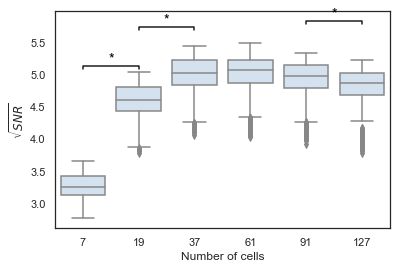

-0.50
-0.50
-0.50
-0.49
-0.45
ISD_Strong-localname_all.pdf


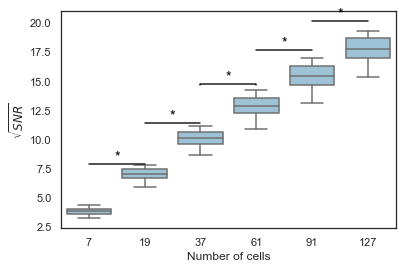

-0.50
-0.50
-0.44
-0.27
-0.15
ISD_Weak-globalname_all.pdf


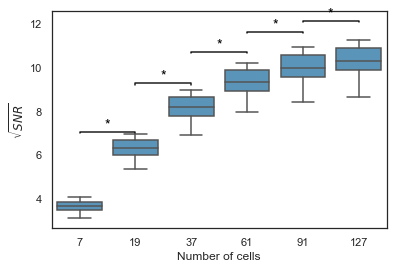

-0.50
-0.50
-0.50
-0.49
-0.46
ISD_Strong-globalname_all.pdf


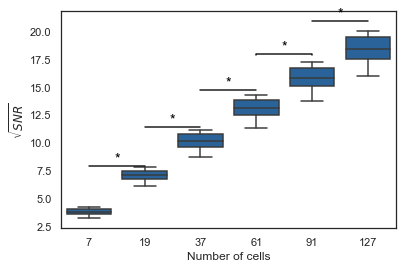

-0.50
-0.25
0.11
0.12
NNE_0.1name_all.pdf


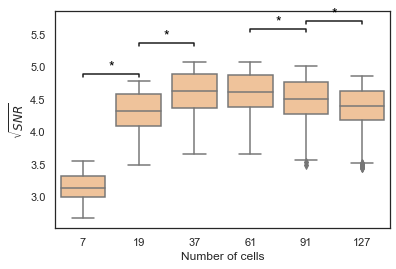

-0.50
-0.50
-0.50
-0.48
-0.44
NNE_10.0name_all.pdf


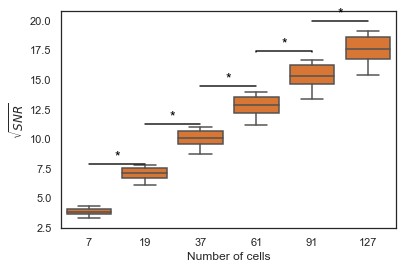

In [27]:
labels_ISD=['D10.0_l1.0_','D10.0_l1.0_','D1000.0_l1.0_','D1000.0_l1.0_']

# Choose the configurations with all hexagonal cells (MPN='4')
MPN='4'

# Generate boxplots for the ISD model
for (sub,lab,col,reg) in zip(subfolders_ISD,labels_ISD,ISD_colors,regime_arr):
    # Select results for the ISD model
    tmp_df=Total_SNR_df[Total_SNR_df['model']=='ISD']
    
    # Select results only for configurations with MPN=6 ('4')
    tmp_df=tmp_df[tmp_df['MPN_lab']==MPN]
    
    # Select results for the given parameter setting
    tmp_df=tmp_df[tmp_df['params']==reg]
    
    MyBoxPlot(tmp_df,'name','SNR','all',col,fig5_folder,reg,save=False)
    
# Generate boxplots for the NNE model
for (ex_rate,col) in zip(ex_rate_list_NN,NN_colors):
    # Select results for the NNE model
    tmp_df=Total_SNR_df[Total_SNR_df['model']=='NNE']
    
    # Select results only for configurations with MPN=6 ('4')
    tmp_df=tmp_df[tmp_df['MPN_lab']==MPN]
    
    # Select results for the given parameter setting
    tmp_df=tmp_df[tmp_df['params']==str(ex_rate)]
    
    MyBoxPlot(tmp_df,'name','SNR','all',col,fig5_folder,str(ex_rate),save=False)

## Supplementary material Figure 5

We show the results on the precision of gradient sensing for different values of the MPN

In [28]:
def MyBoxPlot2(df,x_axis_var,quant,set_label,color,output_folder,param_label,ax,save=True):
    
    g = sns.boxplot(x=x_axis_var, y=quant, data=df,ax=ax,color=color)
    df[x_axis_var]=df[x_axis_var].astype('category')
    coords = get_coordinates_of_seaborn_boxplot(g)
    g.set_xlabel('')
    if x_axis_var=='name':
        x_axis_cat=sorted(list(set(list(df['nr_cells']))))
        g.set_xticklabels([str(cat) for cat in x_axis_cat])
        g.set_xlabel('Number of cells')
    else:
        x_axis_cat=list(set(list(df['MPN_lab'])))
        g.set_xticklabels([5.0,5.25,5.5,5.75,6.0])
        g.set_xlabel('Mean polygon number')

    if quant=='SNR':
        g.set_ylabel(r'$ \sqrt{SNR_N ({\theta})}$')
    elif quant=='mean':
        g.set_ylabel(r'$ \Delta_N ({\theta})$')
    elif quant=='fluc':
        g.set_ylabel(r'$ \delta(\Delta_N)^2 ({\theta})$')
    else:
        print('The quantity that you want to plot does not exist in the dataframe')
    
    # Perform Wilcoxon Rank Sum test between all pairs 
    tmat,pmat,effmat=wilcoxon(df,x_axis_var,quant)
    
    lgth=len(df[x_axis_var].cat.categories)

    counter=0
    for j in range(lgth):
        for k in np.arange(j,lgth,1):
            if pmat[j,k]<0.05 and j!=k and np.abs(j-k)==1 and (effmat[j,k]<0.4 or effmat[j,k]>0.6):
                print(pmat[j,k],effmat[j,k])
                x1=coords[j][0]
                x2=coords[k][0]
                y1=df[df[x_axis_var]==df[x_axis_var].cat.categories[j]][quant].max()
                y2=df[df[x_axis_var]==df[x_axis_var].cat.categories[k]][quant].max()
                y=np.amax([y1,y2])+.05
                    
                h,col=.05,'k'
                ax.plot([x1, x1, x2, x2], [y+counter, y+h+counter, y+h+counter, y+counter], lw=1.5, c=col)
                #if tmat[j,k]>0:
                pcol='black'

                ax.text((x1+x2)*.5, y+h+counter, '*', ha='center', va='bottom', color=pcol,
                              fontsize=16)
                counter+=.2
    print(list(df['model'])[0]+'_'+param_label+x_axis_var+'_'+set_label+'.pdf')

0.0 0.0095166
0.0 0.26035776
9.478573446011847e-103 0.62426944
ISD_Weak-localname_all.pdf
0.0 0.0
0.0 0.00069592
0.0 0.00295156
0.0 0.00659872
0.0 0.0186468
ISD_Strong-localname_all.pdf
0.0 0.0
0.0 0.00819608
0.0 0.04754092
0.0 0.14286392
9.408069893427804e-291 0.28959484
ISD_Weak-globalname_all.pdf
0.0 0.0
0.0 0.00042192
0.0 0.00147576
0.0 0.00442696
0.0 0.00854332
ISD_Strong-globalname_all.pdf
0.0 0.07058668
5.1305202419900394e-73 0.39564592
3.916590392144418e-99 0.62202028
NNE_0.1name_all.pdf
0.0 0.0
0.0 0.00061996
0.0 0.00248728
0.0 0.0086934
0.0 0.01975432
NNE_10.0name_all.pdf
0.0 0.00252768
0.0 0.2413796
5.420218909188835e-131 0.64060776
ISD_Weak-localname_all.pdf
0.0 0.0
0.0 4.584e-05
0.0 0.00150544
0.0 0.00320788
0.0 0.00875316
ISD_Strong-localname_all.pdf
0.0 0.0
0.0 0.0031336
0.0 0.04098616
0.0 0.12775132
1.2856014771593636e-234 0.31116268
ISD_Weak-globalname_all.pdf
0.0 0.0
0.0 1.62e-05
0.0 0.00131772
0.0 0.00154136
0.0 0.00277436
ISD_Strong-globalname_all.pdf
0.0 0.02316336

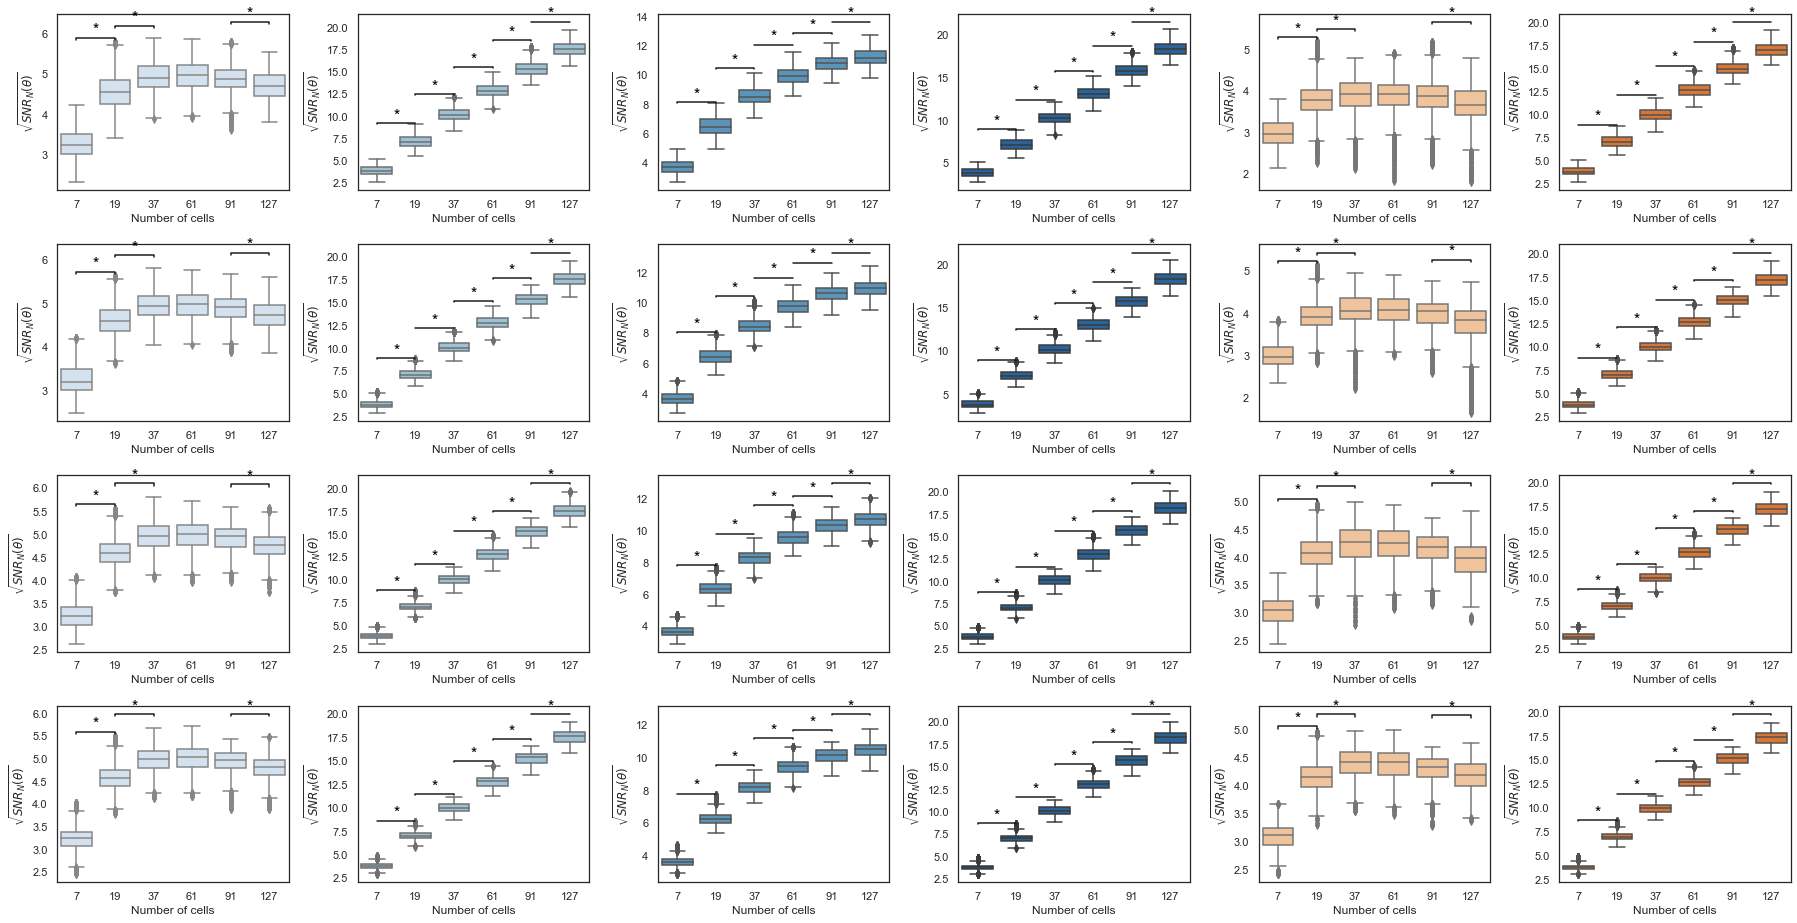

(None, None)

In [29]:
# Choose the configurations with all hexagonal cells (MPN='4')
MPN='4'

fig,ax=plt.subplots(4,6,figsize=(25,13))

i=0
for MPN in ['0','1','2','3']:
    suppfig5_folder=figures_folder+'SUPP_FIG5_'+MPN+'/'
    
    if os.path.isdir(suppfig5_folder)==False:
        os.mkdir(suppfig5_folder)
    # Generate boxplots for the ISD model
    j=0
    for (sub,lab,col,reg) in zip(subfolders_ISD,labels_ISD,ISD_colors,regime_arr):
        
        # Select results for the ISD model
        tmp_df=Total_SNR_df[Total_SNR_df['model']=='ISD']
        
        # Select results only for configurations with MPN=6 ('4')
        tmp_df=tmp_df[tmp_df['MPN_lab']==MPN]
        
        # Select results for the given parameter setting
        tmp_df=tmp_df[tmp_df['params']==reg]    
        
        MyBoxPlot2(tmp_df,'name','SNR','all',col,suppfig5_folder,reg,ax[i,j],save=False)
        j+=1
    # Generate boxplots for the NNE model
    for (ex_rate,col) in zip(ex_rate_list_NN,NN_colors):
        # Select results for the NNE model
        tmp_df=Total_SNR_df[Total_SNR_df['model']=='NNE']
        
        # Select results only for configurations with MPN=6 ('4')
        tmp_df=tmp_df[tmp_df['MPN_lab']==MPN]
        
        # Select results for the given parameter setting
        tmp_df=tmp_df[tmp_df['params']==str(ex_rate)]
        
        MyBoxPlot2(tmp_df,'name','SNR','all',col,suppfig5_folder,str(ex_rate),ax[i,j],save=False)
        j+=1
    i+=1
fig.tight_layout()
# plt.savefig(suppfig5_folder+'new_multipanel.pdf',bbox_inches='tight'),plt.close()
plt.show(),plt.close()

# Figure 6

For each communication model and each parameter setting, we produce a boxplot for the SNR as a function of the mean polygon number (here we choose the configurations with largest number of cells), for 10 sets of configurations.

We mark the p-values from the Wilcoxon rank-sum test as significant if they are smaller than 0.05 and if the common language effect size (CLES) is smaller than 0.4 or larger than 0.6.

In [30]:
fig6_folder=figures_folder+'FIG6/'

if os.path.isdir(fig6_folder)==False:
    os.mkdir(fig6_folder)

In [31]:
Total_SNR_df['MPN_lab']=Total_SNR_df['MPN_lab'].cat.reorder_categories(['0','1','2','3','4'])

## Plots

ISD_Weak-localMPN_lab_all.pdf


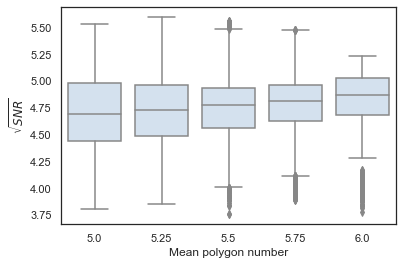

ISD_Strong-localMPN_lab_all.pdf


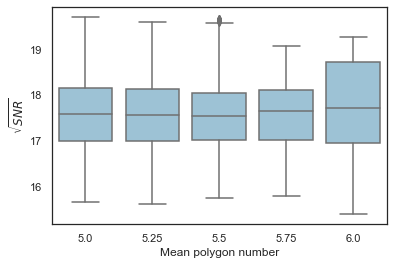

0.14
0.13
0.13
ISD_Weak-globalMPN_lab_all.pdf


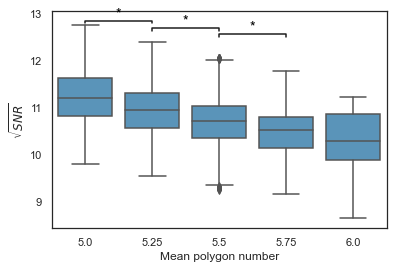

ISD_Strong-globalMPN_lab_all.pdf


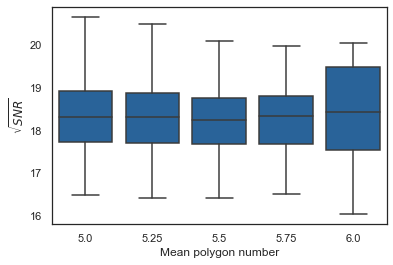

-0.13
-0.19
-0.21
NNE_0.1MPN_lab_all.pdf


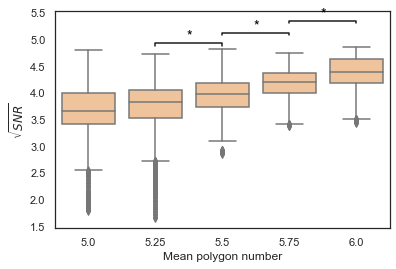

NNE_10.0MPN_lab_all.pdf


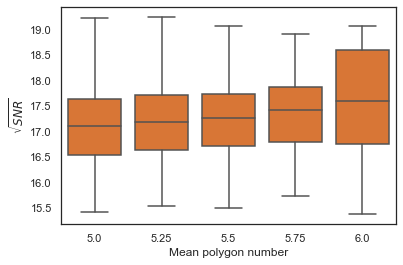

In [32]:
# Choose the configurations with largest number of cells (hexa6)
chosen_conf='hexa6_'

# Generate boxplots for the ISD model
for (sub,lab,col,reg) in zip(subfolders_ISD,labels_ISD,ISD_colors,regime_arr):
    # Select results for the ISD model
    tmp_df=Total_SNR_df[Total_SNR_df['model']=='ISD']
    
    # Select results only for the chosen number of cells
    tmp_df=tmp_df[tmp_df['name']==chosen_conf]
    
    # Select results for the given parameter setting
    tmp_df=tmp_df[tmp_df['params']==reg]
    
    MyBoxPlot(tmp_df,'MPN_lab','SNR','all',col,fig6_folder,reg,save=False)
    
# Generate boxplots for the NNE model
for (ex_rate,col) in zip(ex_rate_list_NN,NN_colors):
    # Select results for the NNE model
    tmp_df=Total_SNR_df[Total_SNR_df['model']=='NNE']
    
    # Select results only for the chosen number of cells
    tmp_df=tmp_df[tmp_df['name']==chosen_conf]
    
    # Select results for the given parameter setting
    tmp_df=tmp_df[tmp_df['params']==str(ex_rate)]
    
    MyBoxPlot(tmp_df,'MPN_lab','SNR','all',col,fig6_folder,str(ex_rate),save=False)

In [33]:
from scipy import interpolate
from scipy.interpolate import CubicSpline,UnivariateSpline
import rpy2.robjects as robjects

def FindEdgeCells(s,num=500):
    x_coords=np.array(s.face_df['x'])
    y_coords=np.array(s.face_df['y'])
    
    xy_coords=np.column_stack((x_coords,y_coords))
    
    #Find the centroid of the configuration
    kmeans_s = KMeans(n_clusters=1, random_state=0).fit(xy_coords)
    centre_s = kmeans_s.cluster_centers_[0]
    
    P=centre_s[0]
    Q=centre_s[1]    
    
    # Define the array of the angles
    theta_arr=np.linspace(0.0,2.0*math.pi,endpoint=True,num=num)
    
    cos_theta = np.cos(theta_arr)
    sin_theta = np.sin(theta_arr)
    
    #Apply the rotation matrix to the initial coordinates
    new_cell_coords=np.array([[[0.0 for i in range(2)] for j in range(s.Nf)] for k in range(len(theta_arr))])
    new_cell_coords[:,:,0]=(xy_coords[np.newaxis,:,0]-P)*cos_theta[:,np.newaxis] + (xy_coords[np.newaxis,:,1]-Q)*sin_theta[:,np.newaxis]+P
    new_cell_coords[:,:,1]=-(xy_coords[np.newaxis,:,0]-P)*sin_theta[:,np.newaxis] + (xy_coords[np.newaxis,:,1]-Q)*cos_theta[:,np.newaxis]+Q
    max_cell_indices=np.argmax(new_cell_coords[:,:,0],axis=1)
    
    return max_cell_indices;

def PlotGammaDist(s_list,gammat_list,normc,output_folder,save=True):

    lab_lst=['5.0','6.0']
    col_lst=['C0','C1']
    fig,ax=plt.subplots()
    s_list=list(reversed(s_list))
    gammat_list=list(reversed(gammat_list))
    ax.set_xlabel('Normalized  distance from cell centroid',fontsize=14)
    ax.set_ylabel(r'$\gamma\;(s^{-1})$ ',fontsize=14)
    print('MPN',' min \u03B3','   max \u03B3','   mean \u03B3','  median \u03B3')
    for (s,gammat,col,lab) in zip(s_list,gammat_list,col_lst,lab_lst):
        x_coords=np.array(s.face_df['x'])
        y_coords=np.array(s.face_df['y'])
        xy_coords=np.column_stack((x_coords,y_coords))
        kmeans_s = KMeans(n_clusters=1, random_state=0).fit(xy_coords)
        centre_s = kmeans_s.cluster_centers_[0]
        
        dist_centroid=np.sqrt( (x_coords - centre_s[0])**2 + (y_coords - centre_s[1])**2 )
        indices_edge_cells=FindEdgeCells(s)
        
        lambda_E=s.edge_df['length'].mean()

        x=[]
        y=[]
        for idx in indices_edge_cells:
            dist_min=np.sqrt( (x_coords - x_coords[idx])**2 + (y_coords - y_coords[idx])**2 )
            x.append(np.delete(dist_min,idx))
            y.append(np.delete(gammat[idx,:],idx))

        # Sort x and y according to x
        x=[item for sublist in x for item in sublist]
        y=[item for sublist in y for item in sublist]
        # Find unique sorted values for x        
        
        unqa,ID,counts = np.unique(x,return_inverse=True,return_counts=True)
        xy = np.column_stack(( unqa , np.bincount(ID,y)/counts ))

        print('%s %.2E %.2E %.2E %.2E' % (lab,np.amin(xy[:,1]),np.amax(xy[:,1]),
                                          np.mean(xy[:,1]),np.median(xy[:,1])))
        
        
        x_range = np.linspace(min(xy[:,0]),max(xy[:,0]), num=100, endpoint=True)

        r_y = robjects.FloatVector(xy[:,1])
        r_x = robjects.FloatVector(xy[:,0])
        
        r_smooth_spline = robjects.r['smooth.spline'] #extract R function# run smoothing function
        spline1 = r_smooth_spline(x=r_x, y=r_y, spar=.7)
        ySpline=np.array(robjects.r['predict'](spline1,robjects.FloatVector(x_range)).rx2('y'))
        RSS=spline1[9]
        print('RSS',RSS)
        ax.plot(x_range/normc,ySpline,label=lab,color=col,lw=3)
        
        ax.set_yscale('log')
        ax.set_ylim(.000001,.2)

    ax.legend(loc=0,frameon=False,title='MPN',fontsize=14)

    fig.tight_layout()
    if save==False:
        plt.show(),plt.close()
    else:
        plt.savefig(output_folder+'new_ex_rate.pdf',bbox_inches='tight'),plt.close()

7.1304254078501526
MPN  min γ    max γ    mean γ   median γ
5.0 0.00E+00 1.49E-01 5.73E-03 2.00E-04
RSS [1] 0.04014503

6.0 0.00E+00 1.48E-01 5.54E-03 0.00E+00
RSS [1] 0.01755779



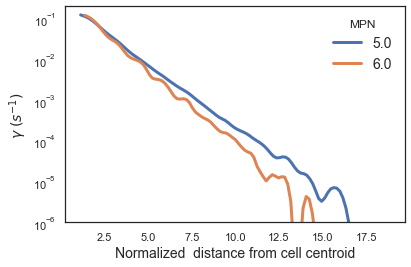

In [34]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

sheet_lst=[]
ex_rate_lst=[]

mylst=[0,4]
lengthlst=[]
for i in range(5):
    if i in mylst:
        # Load a configuration
        dsets = hdf5.load_datasets(conf_folder+'set1_sheet_hexa6_'+str(i)+'.hf5',data_names=['vert', 'edge', 'face'])
        sheet = Sheet('hexa6', dsets)
        lengthlst.append(list(sheet.edge_df['length']))
        sheet_lst.append(sheet)
        filehandler = open(ISD_folder+'set1_Results_D1000.0_l1.0/'+'Matrices_simulation_hexa6_'+str(i)+'.ISD', 'rb')
        res_matrices = pickle.load(filehandler)
        ex_rate_mat_ISD=1.0*res_matrices[1]
        ex_rate_lst.append(ex_rate_mat_ISD)

lengthlst=lengthlst[0]+lengthlst[1]
normconst=np.mean(lengthlst)
print(normconst)

# Load the matrices for the different communication regimes
PlotGammaDist(sheet_lst,ex_rate_lst,normconst,fig6_folder,save=False)

## Supplementary material Figure 6

We show the results on the precision of gradient sensing vs the mean polygon number for different number of cells.

In [35]:
# Choose the configurations with largest number of cells (hexa6)
chosen_conf='hexa6_'

fig,ax=plt.subplots(5,6,figsize=(25,18))
i=0
for chosen_conf in ['hexa1_','hexa2_','hexa3_','hexa4_','hexa5_']:
    
    suppfig6_folder=figures_folder+'SUPP_FIG6_'+chosen_conf+'/'
    
    if os.path.isdir(suppfig6_folder)==False:
        os.mkdir(suppfig6_folder)
    j=0
    # Generate boxplots for the ISD model
    for (sub,lab,col,reg) in zip(subfolders_ISD,labels_ISD,ISD_colors,regime_arr):
        # Select results for the ISD model
        tmp_df=Total_SNR_df[Total_SNR_df['model']=='ISD']
        
        # Select results only for the chosen number of cells
        tmp_df=tmp_df[tmp_df['name']==chosen_conf]
        
        # Select results for the given parameter setting
        tmp_df=tmp_df[tmp_df['params']==reg]
        
        MyBoxPlot2(tmp_df,'MPN_lab','SNR','all',col,suppfig6_folder,reg,ax[i,j],save=False)
        j+=1
        
    # Generate boxplots for the NNE model
    for (ex_rate,col) in zip(ex_rate_list_NN,NN_colors):
        # Select results for the NNE model
        tmp_df=Total_SNR_df[Total_SNR_df['model']=='NNE']
        
        # Select results only for the chosen number of cells
        tmp_df=tmp_df[tmp_df['name']==chosen_conf]
        
        # Select results for the given parameter setting
        tmp_df=tmp_df[tmp_df['params']==str(ex_rate)]
        
        MyBoxPlot2(tmp_df,'MPN_lab','SNR','all',col,suppfig6_folder,str(ex_rate),ax[i,j],save=False)
        j+=1
    i+=1
fig.tight_layout()
# plt.savefig(suppfig6_folder+'new_multipanel.pdf',bbox_inches='tight'),plt.close()
plt.show(),plt.close()

ISD_Weak-localMPN_lab_all.pdf
ISD_Strong-localMPN_lab_all.pdf
ISD_Weak-globalMPN_lab_all.pdf
ISD_Strong-globalMPN_lab_all.pdf
NNE_0.1MPN_lab_all.pdf
NNE_10.0MPN_lab_all.pdf
ISD_Weak-localMPN_lab_all.pdf
ISD_Strong-localMPN_lab_all.pdf
ISD_Weak-globalMPN_lab_all.pdf
ISD_Strong-globalMPN_lab_all.pdf
3.289529679880981e-92 0.38240584
3.255042320259766e-104 0.37483132
1.6218106506238795e-176 0.3364476
NNE_0.1MPN_lab_all.pdf
NNE_10.0MPN_lab_all.pdf
ISD_Weak-localMPN_lab_all.pdf
ISD_Strong-localMPN_lab_all.pdf
ISD_Weak-globalMPN_lab_all.pdf
ISD_Strong-globalMPN_lab_all.pdf
2.4459266178004296e-95 0.38038572
1.3004979687548379e-121 0.36460056
5.653917187309465e-106 0.37375872
1.85879712287282e-234 0.31122772
NNE_0.1MPN_lab_all.pdf
NNE_10.0MPN_lab_all.pdf
ISD_Weak-localMPN_lab_all.pdf
ISD_Strong-localMPN_lab_all.pdf
2.81523874192704e-78 0.60814356
2.704403011334088e-69 0.6015882
ISD_Weak-globalMPN_lab_all.pdf
ISD_Strong-globalMPN_lab_all.pdf
9.46573079867301e-97 0.37948488
3.238473588564709e-110

(None, None)

# Figure 7

Here we compare the precision in gradient sensing between the ISD and NNE models. 

We select the configurations with largest number of cells and, for each value of the mean polygon number, we compute the log ratio of the SNR of the corresponding cell in the ISD and the NNE model

In [36]:
fig7_folder=figures_folder+'FIG7/'

if os.path.isdir(fig7_folder)==False:
    os.mkdir(fig7_folder)

For each configuration and parameter setting in the ISD model, we compute the corresponding exchange rate matrix in the NNE model

In [37]:
# Save the results for the ISD model that have been previously computed
Comp_SNR_df=Total_SNR_df[Total_SNR_df['model']=='ISD']

NNvals_wl=[]
NNvals_sl=[]
NNvals_wg=[]
NNvals_sg=[]

for i in range(nr_sets):
    for j in config_names:
        for k in MPN_list:
            # Identifier for the configuration: set + name + MPN
            identifier='set'+str(i+1)+'_'+j+k
            # Load the configuration
            dsets = hdf5.load_datasets(conf_folder+'set'+str(i+1)+'_sheet_'+str(j)+str(k)+'.hf5',data_names=['vert', 'edge', 'face'])
            sheet = Sheet(identifier, dsets)
            
            # Loop over the parameter settings in the ISD model
            for (sub,emrate,reg) in zip(subfolders_ISD,emrate_arr,regime_arr):
                # Load the matrix of the exchange rates in the ISD model
                filehandler = open(ISD_folder+'set'+str(i+1)+'_'+sub+"Matrices_simulation_"+str(j)+str(k)+'.ISD', 'rb') 
                res_matrices = pickle.load(filehandler)
                ex_rate_mat_ISD=emrate*res_matrices[1]
                elements=[]
                nn_list=[list(sheet.get_neighbors(j)) for j in range(sheet.Nf)]
                for l in range(ex_rate_mat_ISD.shape[0]):
                    elements.append(list(ex_rate_mat_ISD[l,nn_list[l]]))
                ex_rate_NN=np.mean([item for sublist in elements for item in sublist])
                ex_rate_mat_NN=NNMatGen(sheet, ex_rate_NN)

                if j=='hexa6_' and emrate==1.0 and sub=='Results_D10.0_l1.0/':
                    NNvals_wl.append(np.amin(ex_rate_mat_NN[np.nonzero(ex_rate_mat_NN)]))
                if j=='hexa6_' and emrate==100.0 and sub=='Results_D10.0_l1.0/':
                    NNvals_sl.append(np.amin(ex_rate_mat_NN[np.nonzero(ex_rate_mat_NN)]))
                if j=='hexa6_' and emrate==1.0 and sub=='Results_D1000.0_l1.0/':
                    NNvals_wg.append(np.amin(ex_rate_mat_NN[np.nonzero(ex_rate_mat_NN)]))
                if j=='hexa6_' and emrate==100.0 and sub=='Results_D1000.0_l1.0/':
                    NNvals_sg.append(np.amin(ex_rate_mat_NN[np.nonzero(ex_rate_mat_NN)]))
                
                # Compute the SNR
                LEGI_NN_df=SingleConfSNR(sheet,ex_rate_mat_NN,'set'+str(i+1),j,str(np.abs(4-int(k))),'NNE',
                                          LEGI_par_dict,reg)
                
                # Add the results to the dataframe
                Comp_SNR_df=Comp_SNR_df.append(LEGI_NN_df, ignore_index=True)

In [38]:
print(np.amin(NNvals_wl),np.amax(NNvals_wl))
print(np.amin(NNvals_sl),np.amax(NNvals_sl))
print(np.amin(NNvals_wg),np.amax(NNvals_wg))
print(np.amin(NNvals_sg),np.amax(NNvals_sg))

0.10385380116959064 0.112455871886121
10.385380116959064 11.2455871886121
0.07752953736654805 0.08242690058479532
7.752953736654804 8.242690058479532


## Plots

For each communication regime in the ISD model, we produce a scatter plot of SNR_NNE vs SNR_ISD (we plot the mean and the SEM for each), with different markers indicating different values of the MPN.

In [39]:
# Select only the configurations with the largest number of cells 
chosen_conf='hexa6_'

Comp_SNR_df_hexa6=Comp_SNR_df[Comp_SNR_df['name']==chosen_conf]

# For each MPN and each model compute mean and std
res = Comp_SNR_df_hexa6.groupby(['params','MPN_lab', 'model'])['SNR'].mean().reset_index()
res2 = Comp_SNR_df_hexa6.groupby(['params','MPN_lab', 'model'])['SNR'].std().reset_index()
res['std']=res2['SNR']

Results_D10.0_l1.0/


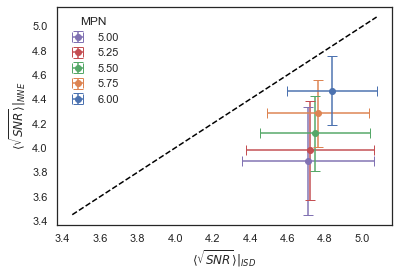

Results_D10.0_l1.0/


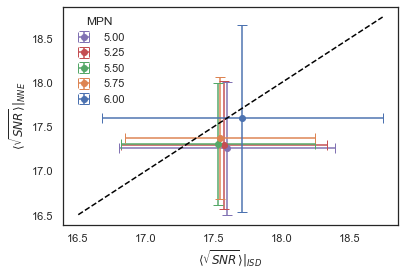

Results_D1000.0_l1.0/


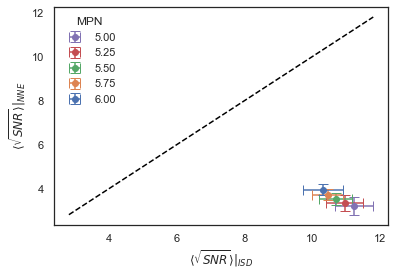

Results_D1000.0_l1.0/


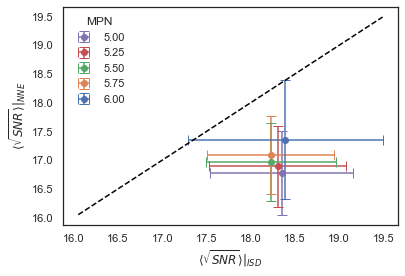

In [41]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

mpn_vals=['5.00','5.25','5.50','5.75','6.00']
mpn_cols=['C4','C3','C2','C1','C0']

for (sub,reg) in zip(subfolders_ISD,regime_arr):
    mymin=[]
    mymax=[]
    print(sub)
    tmp_df=res[res['params']==reg]
    fig,ax=plt.subplots()
    for i in range(5):
        tmp_tmp_df=tmp_df[tmp_df['MPN_lab']==str(i)]
        x=tmp_tmp_df[tmp_tmp_df['model']=='ISD']['SNR']
        y=tmp_tmp_df[tmp_tmp_df['model']=='NNE']['SNR']
        xerr=tmp_tmp_df[tmp_tmp_df['model']=='ISD']['std']
        yerr=tmp_tmp_df[tmp_tmp_df['model']=='NNE']['std']
        ax.errorbar(x, y,xerr=xerr, yerr=yerr,fmt='o',capsize=5,label=mpn_vals[i],color=mpn_cols[i])
        xmin=np.amin(x)-xerr
        xmax=np.amax(x)+xerr
        ymin=np.amin(y)-yerr
        ymax=np.amax(y)+yerr
        
        mymin.append(np.amin([xmin,ymin]))
        mymax.append(np.amax([xmax,ymax]))
    xline=np.linspace(np.amin(mymin),np.amax(mymax),num=20,endpoint=True)
    yline=xline[:]
    
    # Comment this for the inset
    ax.set_xlabel(r'$\langle \sqrt{SNR} \rangle|_{ISD}$')
    ax.set_ylabel(r'$\langle \sqrt{SNR} \rangle|_{NNE}$')
    ax.legend(loc=0,frameon=False,title='MPN')
    ##########################################
    
    ax.plot(xline,yline,color='black',linestyle='dashed')
    plt.show(),plt.close()
    # Uncomment this for the inset
#     ax.set_xlim(9,12)
#     ax.set_ylim(2.5,4.5)
#     ax.tick_params(axis='both', which='major', labelsize=20)
#     ax.tick_params(axis='both', which='minor', labelsize=20)
#     if reg=='Weak-global':
#         plt.savefig(fig7_folder+'cmp_'+reg+'inset.pdf',bbox_inches='tight'),plt.close()
        
    ##########################################
    
    # Comment this for the inset
#     plt.savefig(fig7_folder+'cmp_'+reg+'.pdf',bbox_inches='tight'),plt.close()
    

## Supplementary material Figure 7

We show the comparison between ISD and NNE models for different number of cells.

Results_D10.0_l1.0/


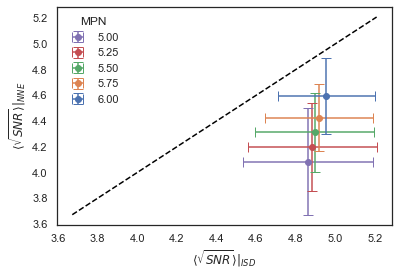

Results_D10.0_l1.0/


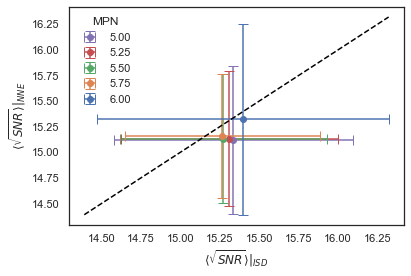

Results_D1000.0_l1.0/


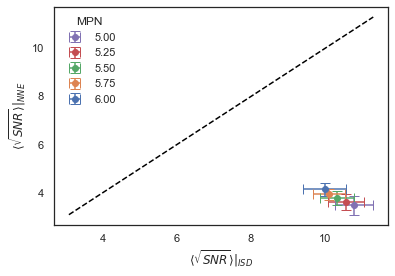

Results_D1000.0_l1.0/


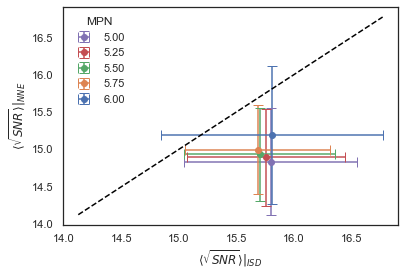

Results_D10.0_l1.0/


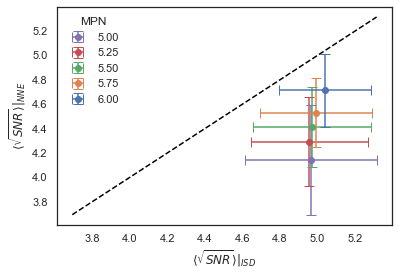

Results_D10.0_l1.0/


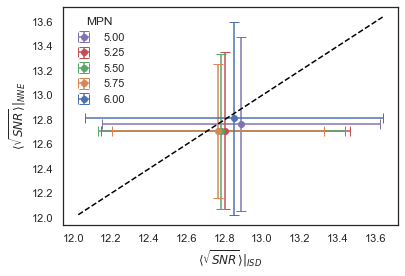

Results_D1000.0_l1.0/


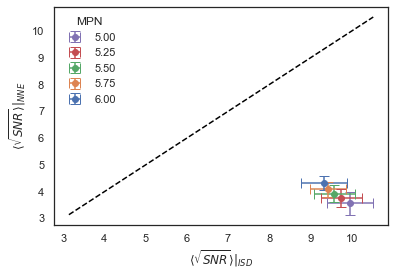

Results_D1000.0_l1.0/


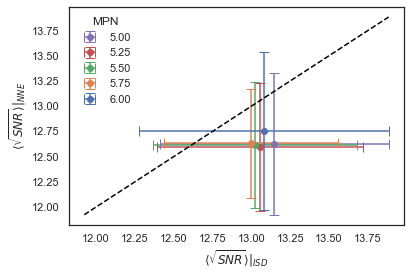

Results_D10.0_l1.0/


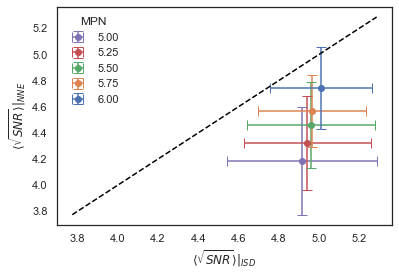

Results_D10.0_l1.0/


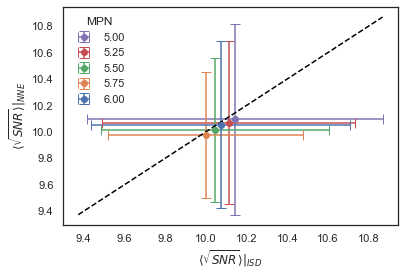

Results_D1000.0_l1.0/


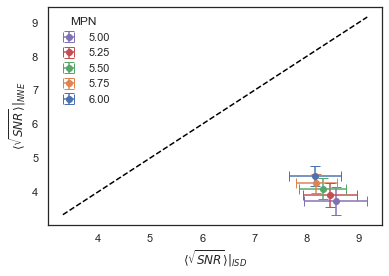

Results_D1000.0_l1.0/


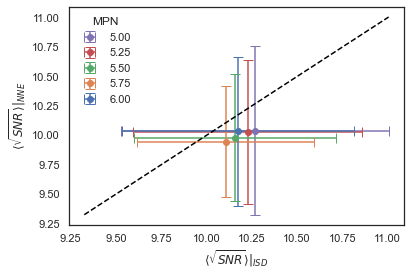

Results_D10.0_l1.0/


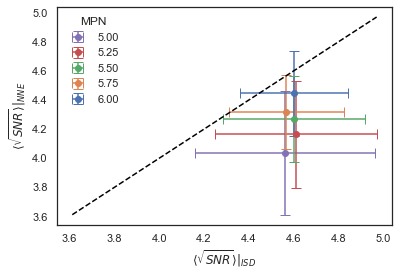

Results_D10.0_l1.0/


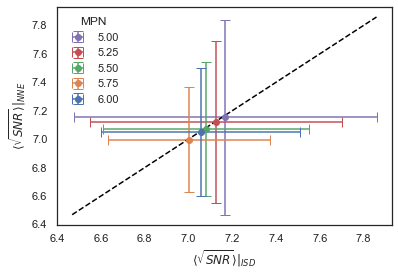

Results_D1000.0_l1.0/


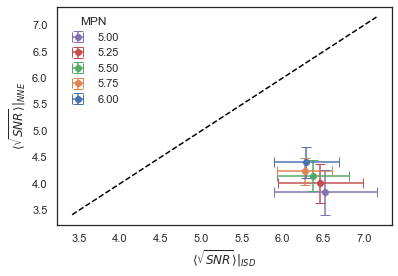

Results_D1000.0_l1.0/


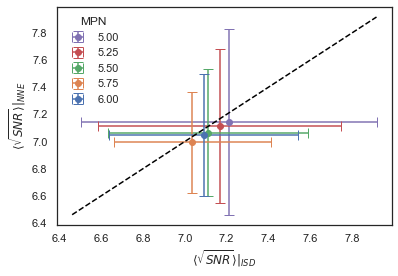

Results_D10.0_l1.0/


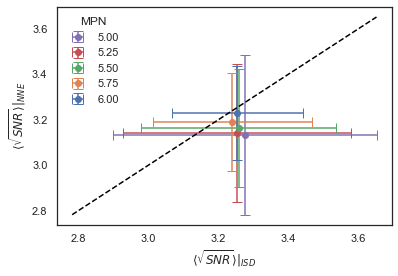

Results_D10.0_l1.0/


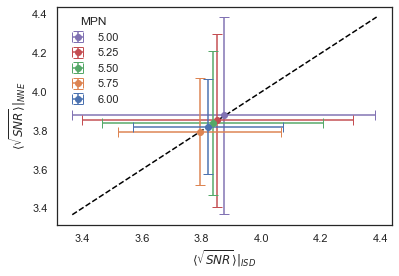

Results_D1000.0_l1.0/


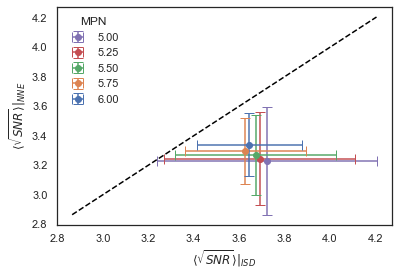

Results_D1000.0_l1.0/


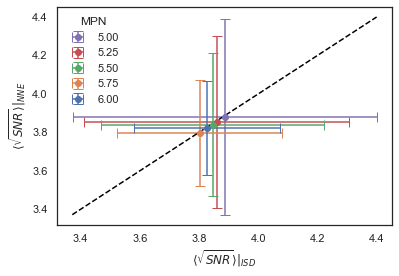

In [42]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

for chosen_conf in ['hexa5_','hexa4_','hexa3_','hexa2_','hexa1_']:
    
    suppfig7_folder=figures_folder+'SUPP_FIG7_'+chosen_conf+'/'
    
    if os.path.isdir(suppfig7_folder)==False:
        os.mkdir(suppfig7_folder)
    
    
    Comp_SNR_df_tmp=Comp_SNR_df[Comp_SNR_df['name']==chosen_conf]
    
    # For each MPN and each model compute mean and std
    res = Comp_SNR_df_tmp.groupby(['params','MPN_lab', 'model'])['SNR'].mean().reset_index()
    res2 = Comp_SNR_df_tmp.groupby(['params','MPN_lab', 'model'])['SNR'].std().reset_index()
    res['std']=res2['SNR']
    
    mpn_vals=['5.00','5.25','5.50','5.75','6.00']
    mpn_cols=['C4','C3','C2','C1','C0']
    
    for (sub,lab,reg) in zip(subfolders_ISD,labels_ISD,regime_arr):
        mymin=[]
        mymax=[]
        print(sub)
        tmp_df=res[res['params']==reg]
        fig,ax=plt.subplots()
        for i in range(5):
            tmp_tmp_df=tmp_df[tmp_df['MPN_lab']==str(i)]
            x=tmp_tmp_df[tmp_tmp_df['model']=='ISD']['SNR']
            y=tmp_tmp_df[tmp_tmp_df['model']=='NNE']['SNR']
            xerr=tmp_tmp_df[tmp_tmp_df['model']=='ISD']['std']
            yerr=tmp_tmp_df[tmp_tmp_df['model']=='NNE']['std']
            ax.errorbar(x, y,xerr=xerr, yerr=yerr,fmt='o',capsize=5,label=mpn_vals[i],color=mpn_cols[i])
            xmin=np.amin(x)-xerr
            xmax=np.amax(x)+xerr
            ymin=np.amin(y)-yerr
            ymax=np.amax(y)+yerr
            mymin.append(np.amin([xmin,ymin]))
            mymax.append(np.amax([xmax,ymax]))
        xline=np.linspace(np.amin(mymin),np.amax(mymax),num=20,endpoint=True)
        yline=xline[:]
    
        ax.set_xlabel(r'$\langle \sqrt{SNR} \rangle|_{ISD}$')
        ax.set_ylabel(r'$\langle \sqrt{SNR} \rangle|_{NNE}$')
        ax.legend(loc=0,frameon=False,title='MPN')
    
        ax.plot(xline,yline,color='black',linestyle='dashed')
        plt.show(),plt.close()
    
#         plt.savefig(suppfig7_folder+'cmp_'+reg+'.pdf',bbox_inches='tight'),plt.close()

# Figure S1

For each communication model and each parameter setting, we produce two boxplots for the means and fluctuations of the readout variable as a function of the number of cells (here we choose the configurations with largest mean polygon number), for 10 sets of configurations.

We mark the p-values from the Wilcoxon rank-sum test as significant if they are smaller than 0.05 and if the common language effect size (CLES) is smaller than 0.4 or larger than 0.6.

In [43]:
figS1_folder=figures_folder+'FIGS1/'

if os.path.isdir(figS1_folder)==False:
    os.mkdir(figS1_folder)

## Plots

-0.50
-0.44
-0.20
ISD_Weak-localname_all.pdf


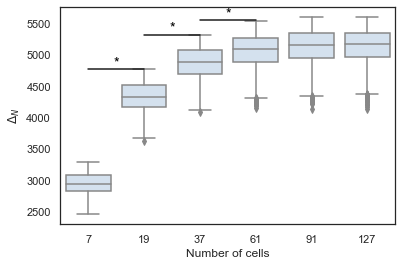

-0.50
-0.49
-0.49
-0.48
-0.47
ISD_Weak-localname_all.pdf


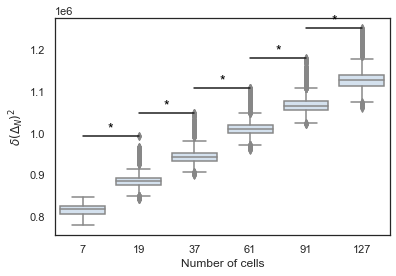

-0.50
-0.50
-0.50
-0.50
-0.47
ISD_Strong-localname_all.pdf


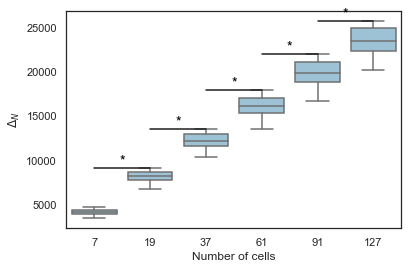

-0.50
-0.50
-0.50
-0.50
-0.50
ISD_Strong-localname_all.pdf


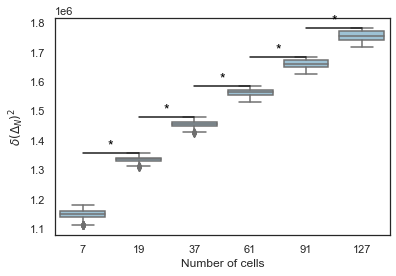

-0.50
-0.50
-0.47
-0.34
-0.23
ISD_Weak-globalname_all.pdf


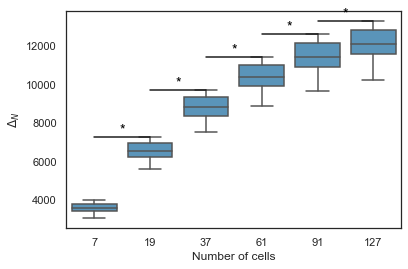

-0.50
-0.50
-0.50
-0.50
-0.50
ISD_Weak-globalname_all.pdf


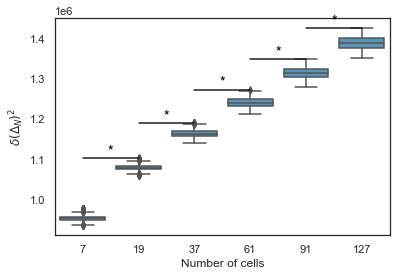

-0.50
-0.50
-0.50
-0.50
-0.48
ISD_Strong-globalname_all.pdf


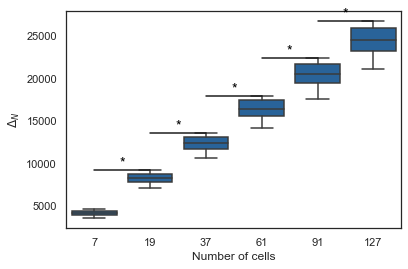

-0.50
-0.50
-0.50
-0.50
-0.50
ISD_Strong-globalname_all.pdf


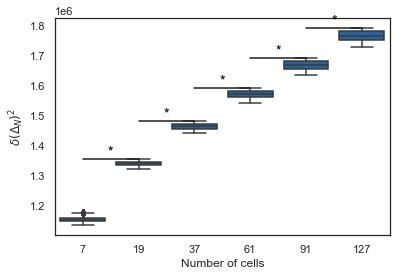

-0.50
-0.33
-0.13
NNE_0.1name_all.pdf


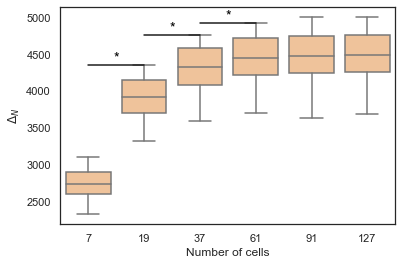

-0.50
-0.49
-0.48
-0.48
-0.48
NNE_0.1name_all.pdf


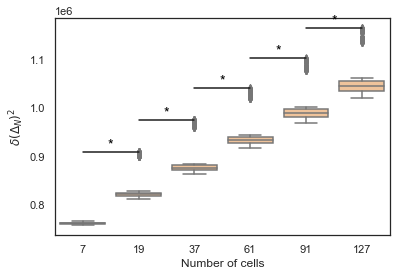

-0.50
-0.50
-0.50
-0.50
-0.46
NNE_10.0name_all.pdf


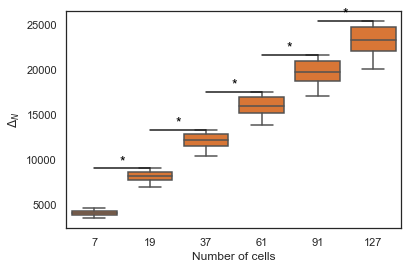

-0.50
-0.50
-0.50
-0.50
-0.50
NNE_10.0name_all.pdf


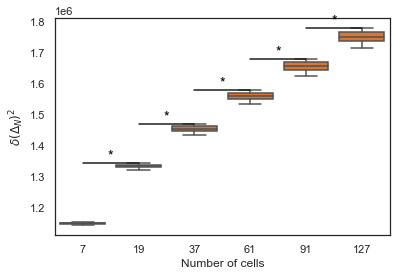

In [44]:
# Choose the configurations with all hexagonal cells (MPN='0')
MPN='4'

# Generate boxplots for the ISD model
for (sub,lab,col,reg) in zip(subfolders_ISD,labels_ISD,ISD_colors,regime_arr):
    # Select results for the ISD model
    tmp_df=Total_SNR_df[Total_SNR_df['model']=='ISD']
    
    # Select results only for configurations with MPN=6 ('0')
    tmp_df=tmp_df[tmp_df['MPN_lab']==MPN]
    
    # Select results for the given parameter setting
    tmp_df=tmp_df[tmp_df['params']==reg]
    
    MyBoxPlot(tmp_df,'name','mean','all',col,figS1_folder,reg,save=False)
    MyBoxPlot(tmp_df,'name','fluc','all',col,figS1_folder,reg,save=False)
    
# Generate boxplots for the NNE model
for (ex_rate,col) in zip(ex_rate_list_NN,NN_colors):
    # Select results for the NNE model
    tmp_df=Total_SNR_df[Total_SNR_df['model']=='NNE']
    
    # Select results only for configurations with MPN=6 ('0')
    tmp_df=tmp_df[tmp_df['MPN_lab']==MPN]
    
    # Select results for the given parameter setting
    tmp_df=tmp_df[tmp_df['params']==str(ex_rate)]
    
    MyBoxPlot(tmp_df,'name','mean','all',col,figS1_folder,str(ex_rate),save=False)
    MyBoxPlot(tmp_df,'name','fluc','all',col,figS1_folder,str(ex_rate),save=False)